# Аналитика в Яндекс.Афише

На основании данных о посещениях сайта Яндекс.Афиши изучить как люди пользуются продуктом, когда они начинают покупать, сколько денег приносит каждый клиент, когда он окупается.

**План исследования**
1. [Загрузка и подготовка данных](#start)
2. [Построение отчётов и подсчет метрик](#kpi)

    -[Продукт](#product)
    
    -[Продажи](#sale)
    
    -[Маркетинг](#marketing)
    
    
3. [Общий вывод](#conclusion)

## Шаг 1. Загрузка и подготовка данных <a id='start'></a>

Загрузим данные о визитах, заказах и расходах в переменные. Оптимизируем данные для анализа. Проверим правильнось типов данных в каждой колонке.

In [128]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [129]:
visits = pd.read_csv('/datasets/visits_log.csv')
visits.head()

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [130]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


Таблица visits (лог сервера с информацией о посещениях сайта) содержит 359400 строк и 5 столбцов: Uid — уникальный идентификатор пользователя, Device — категория устройства пользователя, Start Ts — дата и время начала сессии, End Ts — дата и время окончания сессии, Source Id — идентификатор рекламного источника, из которого пришел пользователь. Пропуски отсутствуют.


Переименуем названия столбцов в таблице.

In [131]:
visits.columns = visits.columns.str.lower().str.replace(' ','_')
visits.columns

Index(['device', 'end_ts', 'source_id', 'start_ts', 'uid'], dtype='object')

Заменим типы данных в столбцах end_ts и start_ts на дату.

In [132]:
visits['end_ts'] = pd.to_datetime(visits['end_ts'], format='%Y-%m-%dT%H:%M:%S')

In [133]:
visits['start_ts'] = visits['start_ts'].astype('datetime64')

Проверим за какой период представлены данные.

In [134]:
visits['start_ts'].describe()

count                  359400
unique                 224303
top       2017-11-24 16:06:00
freq                       19
first     2017-06-01 00:01:00
last      2018-05-31 23:59:00
Name: start_ts, dtype: object

In [135]:
visits['end_ts'].describe()

count                  359400
unique                 224760
top       2017-11-24 16:51:00
freq                       23
first     2017-06-01 00:02:00
last      2018-06-01 01:26:00
Name: end_ts, dtype: object

Встречаются записи за 2018-06-01. Удалим их из рассмотрения, так как анализ будем вести по май 2018 года включительно. Несколько записей за 2018-06-01 исказят данные.

In [136]:
visits = visits[visits['end_ts']<'2018-06-01']

In [137]:
orders = pd.read_csv('/datasets/orders_log.csv')
orders.head()

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [138]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


Таблица orders (информация о заказах) содержит 50415 строк и 3 столбца: Uid — уникальный id пользователя, который сделал заказ, Buy Ts — дата и время заказа, Revenue — выручка Яндекс.Афиши с этого заказа. Пропусков нет.

Переименуем названия столбцов в таблице.

In [139]:
orders.columns = orders.columns.str.lower().str.replace(' ','_')
orders.columns

Index(['buy_ts', 'revenue', 'uid'], dtype='object')

Заменим тип данных в столбце buy_ts на дату.

In [140]:
orders['buy_ts'] = orders['buy_ts'].astype('datetime64')

Проверим за какой период представлены данные.

In [141]:
orders['buy_ts'].describe()

count                   50415
unique                  45991
top       2018-05-31 10:13:00
freq                        9
first     2017-06-01 00:10:00
last      2018-06-01 00:02:00
Name: buy_ts, dtype: object

Так как за июнь 2018г. всего одна запись, то удалим ее, так как данная запись исказит выводы о средних значениях и графики.

In [142]:
orders = orders[orders['buy_ts']<'2018-06-01']

In [143]:
costs = pd.read_csv('/datasets/costs.csv')
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [144]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


Таблица costs  (информация о затратах на маркетинг) содержит 2542 строки и 3 столбца: source_id — идентификатор рекламного источника, dt — дата, costs — затраты на этот рекламный источник в этот день. Пропусков нет.

Заменим тип данных в столбце ds на дату и проверим за какой период представлены данные.

In [145]:
costs['dt'] = costs['dt'].astype('datetime64')

In [146]:
costs['dt'].describe()

count                    2542
unique                    364
top       2018-03-03 00:00:00
freq                        7
first     2017-06-01 00:00:00
last      2018-05-31 00:00:00
Name: dt, dtype: object

## Шаг 2. Построение отчётов и подсчет метрик <a id='kpi'></a>

### Продукт <a id='product'></a>

#### Ежедневное, недельное и месячное использование сайта

Чтобы посчитать ежедневное, недельное и месячное использование, выделим в отдельные столбцы месяц и неделю, а также полную дату значения start_ts в датафрейме visits.

In [147]:
visits['start_ts_date'] = visits['start_ts'].astype('datetime64[D]') #размерность временной сетки - день
visits['start_ts_week'] = visits['start_ts'].astype('datetime64[W]') #размерность временной сетки - неделя
visits['start_ts_month'] = visits['start_ts'].astype('datetime64[M]') #размерность временной сетки - месяц

visits.head(3)

,device,end_ts,source_id,start_ts,uid,start_ts_date,start_ts_week,start_ts_month
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017-12-14,2017-12-01
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2018-02-15,2018-02-01
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-06-29,2017-07-01


Построим гистограмму с данными о числе пользователей, ежедневно заходящих на сайт.

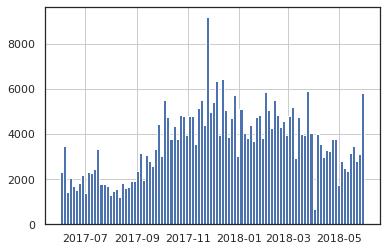

In [148]:
visits['start_ts_date'].hist(bins=100)
plt.show()

In [149]:
print(visits.groupby('start_ts_date').agg({'uid':'nunique'}).mean())

uid    907.967033
dtype: float64


Заметим, что меньшее число пользователей заходило на сайт в июне-августе 2017г, а больше всего в 4-ом квартале 2017г. и 1-ом квартале 2018г. В среднем на сайт заходят 907 человек за день.

Рассмотрим подробнее на графиках число пользователей,заходящих на сайт за день и как число пользователей сайта отличается по устройствам device и по рекламным источникам source_id?

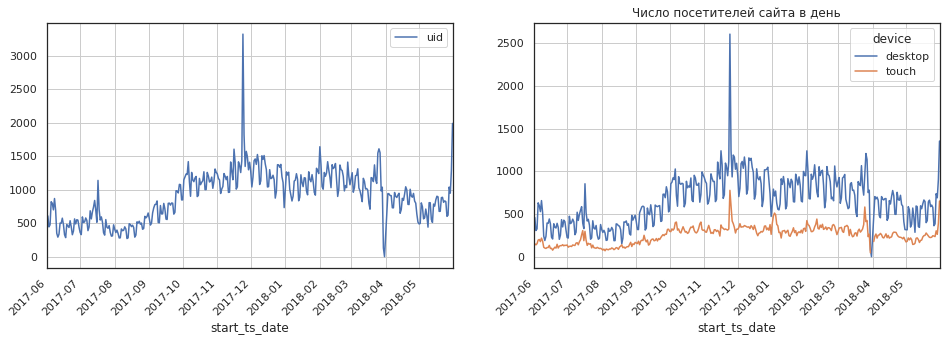

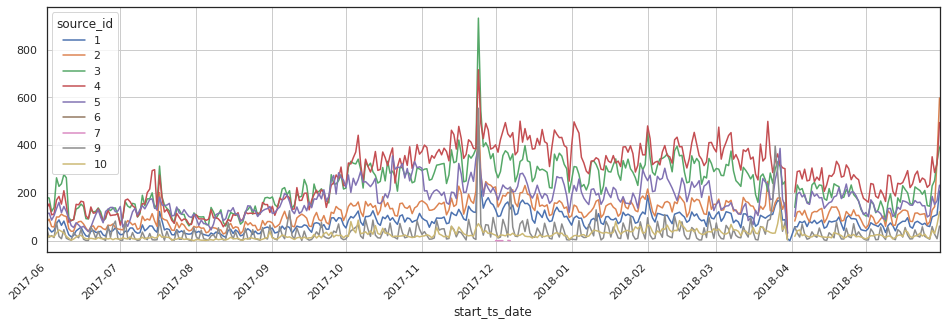

In [150]:
plt.subplots(figsize=(16,5)) # создание таблицы для отрисовки графиков вместе

visits.groupby('start_ts_date').agg({'uid':'nunique'}).plot(grid=True,rot=45,ax=plt.subplot(1,2,1))
pd.pivot_table(visits,
              index='start_ts_date',
               columns='device',
               values='uid',
               aggfunc='nunique').plot(grid=True,rot=45,ax=plt.subplot(1,2,2))
plt.title('Число посетителей сайта в день')
pd.pivot_table(visits,
              index='start_ts_date',
               columns='source_id',
               values='uid',
               aggfunc='nunique').plot(grid=True,rot=45,figsize=(16,5))

plt.show()


Итак,  меньшее число пользователей заходило на сайт в июне-августе 2017г, а наибольшее число в 4-ом квартале 2017г. и 1-ом квартале 2018г. Число пользоватей, заходящих на сайт с компьютера,значительно превышает число пользователей,заходящих с телефона/планшета. Из рассматриваемых источников рекламы 1,2,3,4,5,6,7,9,10 в основном пользователи из 3,4 и 5го,практически отсутствуют посетители, пришедшие из 6,7 источников.

In [151]:
pd.pivot_table(visits,
            index='source_id',
            values='uid',
            aggfunc='nunique').sort_values(by='uid',ascending=False)

,source_id,uid
source_id,,
4,1,83523
3,1,74755
5,1,56972
2,1,26244
1,1,18998
9,1,9264
10,1,8066
7,1,34
6,1,6




Рассмотрим на графиках число посетителей сайта за неделю и как количество пользователей сайта отличаются по устройствам device и по рекламным источникам source_id? 

In [152]:
visits.groupby(['start_ts_week']).agg({'uid':'nunique'}).describe()

,uid
count,53.000000
mean,5724.245283
std,2096.428051
min,1988.000000
25%,4056.000000
50%,5894.000000
75%,7441.000000
max,10716.000000


Среднее число пользователей сайта за неделю 5724 человек.

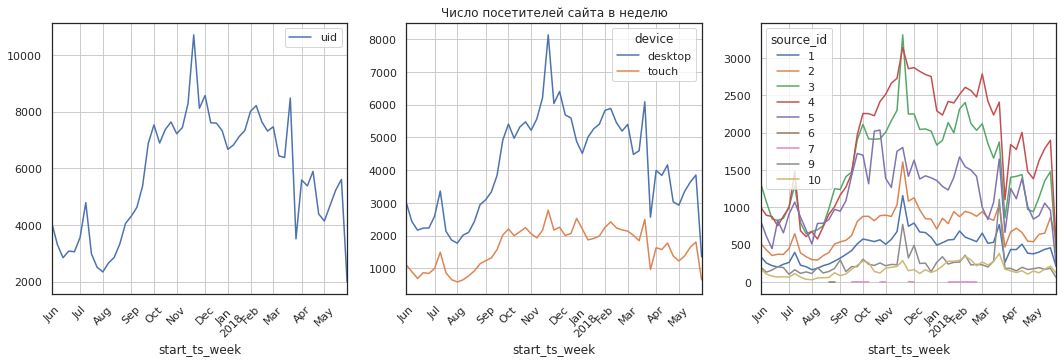

In [153]:
plt.subplots(figsize=(18,5)) # создание таблицы для отрисовки графиков вместе

visits.groupby(['start_ts_week']).agg({'uid':'nunique'}).plot(grid=True,rot=45,ax=plt.subplot(1,3,1))
pd.pivot_table(visits,
              index=['start_ts_week'],
               columns='device',
               values='uid',
               aggfunc='nunique').plot(grid=True,rot=45,ax=plt.subplot(1,3,2))
plt.title('Число посетителей сайта в неделю')
pd.pivot_table(visits,
              index=['start_ts_week'],
              columns='source_id',
              values='uid',
              aggfunc='nunique').plot(grid=True,rot=45,ax=plt.subplot(1,3,3))

plt.show()

Итак,  меньшее число пользователей заходило на сайт в июне-августе 2017г, а наибольшее число в 4-ом квартале 2017г. и 1-ом квартале 2018г. Число пользоватей, заходящих на сайт с компьютера,значительно превышает число пользователей,заходящих с телефона/планшета. Из рассматриваемых источников рекламы 1,2,3,4,5,6,7,9,10 в основном пользователи из 3,4 и 5го,практически отсутствуют посетители, пришедшие из 6,7 источников.Т.е. вывод такой же как и в ежедневном анализе.



Рассмотрим на графиках число посетителей сайта за месяц и как количество пользователей сайта отличаются по устройствам device и по рекламным источникам source_id? 

In [154]:
visits.groupby(['start_ts_month']).agg({'uid':'nunique'}).describe()

,uid
count,12.000000
mean,23227.833333
std,7546.593859
min,11631.000000
25%,17777.000000
50%,24240.500000
75%,28984.750000
max,32797.000000


Среднее число пользователей сайта в месяц 23228 человек.

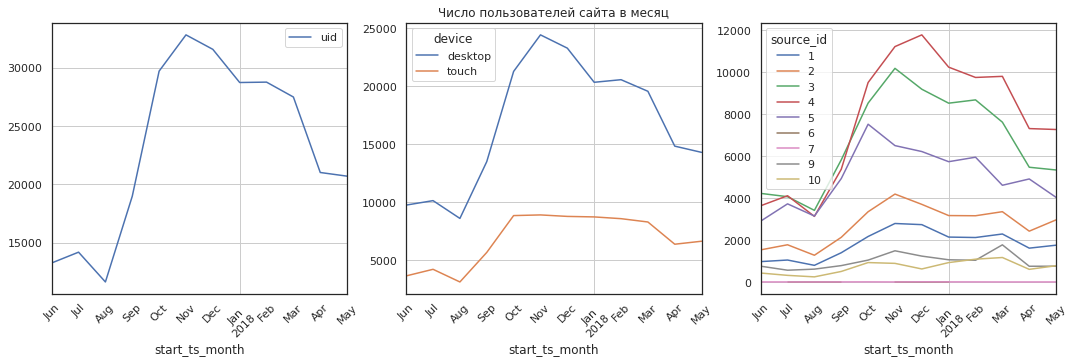

In [155]:
plt.subplots(figsize=(18,5)) # создание таблицы для отрисовки графиков вместе

visits.groupby(['start_ts_month']).agg({'uid':'nunique'}).plot(grid=True,rot=45,ax=plt.subplot(1,3,1))
pd.pivot_table(visits,
              index=['start_ts_month'],
               columns='device',
               values='uid',
               aggfunc='nunique').plot(grid=True,rot=45,ax=plt.subplot(1,3,2))
plt.title('Число пользователей сайта в месяц')
pd.pivot_table(visits,
              index=['start_ts_month'],
               columns='source_id',
               values='uid',
               aggfunc='nunique').plot(grid=True,rot=45,ax=plt.subplot(1,3,3))

plt.show()

Итак,  меньшее число пользователей заходило на сайт в июне-августе 2017г, а наибольшее число в 4-ом квартале 2017г. и 1-ом квартале 2018г. Число пользоватей, заходящих на сайт с компьютера,значительно превышает число пользователей,заходящих с телефона/планшета. Из рассматриваемых источников рекламы 1,2,3,4,5,6,7,9,10 в основном пользователи из 3,4 и 5го,практически отсутствуют посетители, пришедшие из 6,7 источников. Данный вывод одинаков для ежедневного, еженедельного и месячного анализа.

#### Количество сессий в день

Рассмотрим количество сессий в день.

In [156]:
print(visits.groupby('start_ts_date').agg({'start_ts':'count'}).mean())

start_ts    987.32967
dtype: float64


В среднем в день 987 сессий.

Рассмотрим подробнее на графиках количество сессий за день и как это количество отличается по устройствам device и по рекламным источникам source_id?

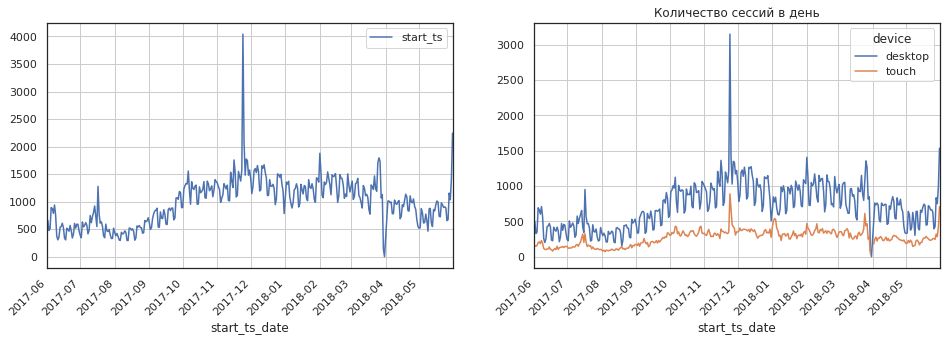

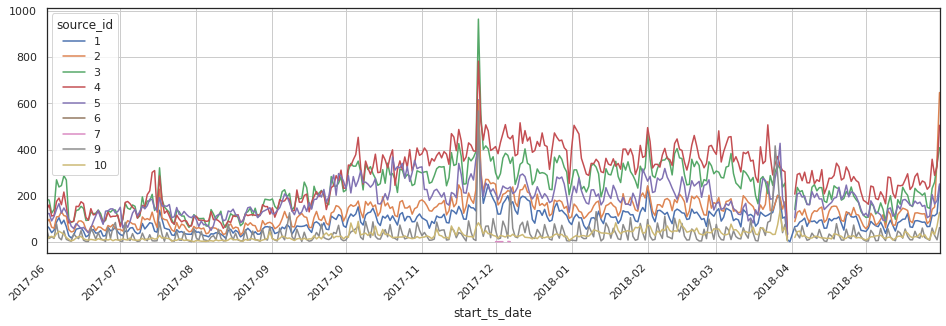

In [157]:
plt.subplots(figsize=(16,5)) 

visits.groupby('start_ts_date').agg({'start_ts':'count'}).plot(grid=True,rot=45,ax=plt.subplot(1,2,1))
pd.pivot_table(visits,
              index='start_ts_date',
               columns='device',
               values='start_ts',
               aggfunc='count').plot(grid=True,rot=45,ax=plt.subplot(1,2,2))
plt.title('Количество сессий в день')
pd.pivot_table(visits,
              index='start_ts_date',
               columns='source_id',
               values='start_ts',
               aggfunc='count').plot(grid=True,rot=45,figsize=(16,5))

plt.show()


In [158]:
pd.pivot_table(visits,
            index='source_id',
            values='start_ts',
            aggfunc='count').sort_values(by='start_ts',ascending=False)

,start_ts
source_id,
4,101790
3,85609
5,66903
2,47624
1,34119
9,13277
10,10024
7,36
6,6


Итак,  минимальное коичество сессий в июне-августе 2017г, а максимальное количество в 4-ом квартале 2017г. и 1-ом квартале 2018г. Количество сессий с компьютера,значительно превышает количество с телефона/планшета. Из рассматриваемых источников рекламы 1,2,3,4,5,6,7,9,10 в основном сессии из 3,4 и 5го,практически отсутствуют из 6,7 источников.

#### Длительность одной сессии

Рассчитаем сколько по времени длится одна сессия. Найдем разность между концом и начлом сессии и выразим полученное значение в секундах.

In [159]:
visits['session_duration'] = (visits['end_ts'] - visits['start_ts']).dt.seconds
visits['session_duration'].describe()

count    359388.000000
mean        643.465703
std        1016.280993
min           0.000000
25%         120.000000
50%         300.000000
75%         840.000000
max       84480.000000
Name: session_duration, dtype: float64

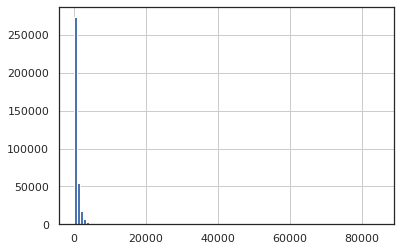

In [160]:
visits['session_duration'].hist(bins=100)
plt.show()

По гистограмме видно, что распределение не похоже на нормальное и очень много значение находится около нуля.  Рассчитаем моду (значение в выборке, которое встречается чаще всего).

In [161]:
print(visits['session_duration'].mode())

0    60
dtype: int64


В среднем сессия длится 643 сек, медианное значение 300 сек, а мода равна 60 сек. 

Построим boxplot для длины сессии в целом, по устройствам device и по рекламным источникам source_id.

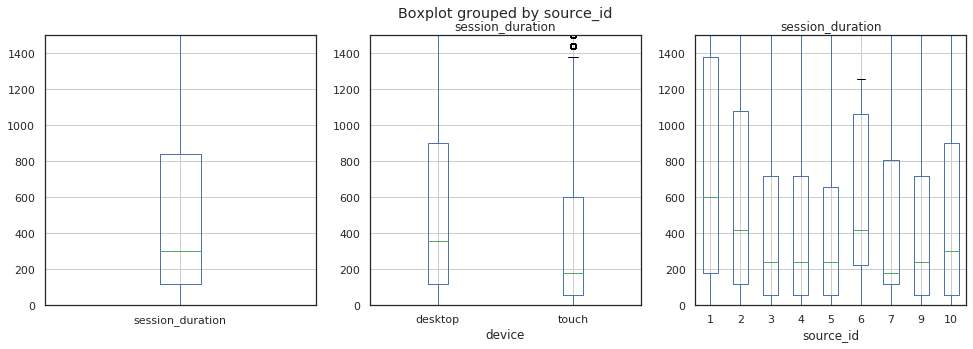

In [162]:
# строим диаграммы размаха
plt.subplots(figsize=(16,5))
visits.boxplot('session_duration',ax=plt.subplot(1,3,1))
plt.ylim(0,1500)
visits.boxplot('session_duration',by='device',ax=plt.subplot(1,3,2))
plt.ylim(0,1500)
visits.boxplot('session_duration',by='source_id',ax=plt.subplot(1,3,3))
plt.ylim(0,1500)
plt.show()

Большинство сессий длится 300 сек. (медианное значение), но встречается и довольно много выбросов. Сессии на компьюьерах длиннее (почти 400 сек), чем на телефонах/планшетах (почти 200 сек.). Самые длинные сессии у пользователей, пришедших через рекламные источники 1 (самые длинные),2,6, а самые короткие сессии у пользователей, пришедших через рекламные источники 7,4,5,6,9 (около 200 сек.).

#### Как часто люди возвращаются?

Найдем дату, когда пользователь впервые проявил активность на сайте.

In [163]:
# группируем данные по пользователям и находим первую (минимальную) дату посещения
first_activity_date = visits.groupby('uid')['start_ts_month'].min() 
first_activity_date.name = 'first_activity_date'
first_activity_date.head()

uid
11863502262781    2018-03-01
49537067089222    2018-02-01
297729379853735   2017-06-01
313578113262317   2017-09-01
325320750514679   2017-09-01
Name: first_activity_date, dtype: datetime64[ns]

Объединим first_activity_date с исходным датафреймом visits, т.е. каждому пользователю припишем дату, когда он впервые проявил активность на сайте.

In [164]:
customer = pd.merge(visits,first_activity_date,on='uid')
customer.head()

,device,end_ts,source_id,start_ts,uid,start_ts_date,start_ts_week,start_ts_month,session_duration,first_activity_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017-12-14,2017-12-01,1080,2017-12-01
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2018-02-15,2018-02-01,1680,2018-02-01
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-06-29,2017-07-01,0,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,2018-05-17,2018-05-01,1440,2018-03-01
4,desktop,2018-03-09 20:33:00,4,2018-03-09 20:05:00,16174680259334210214,2018-03-09,2018-03-08,2018-03-01,1680,2018-03-01


In [165]:
customer.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 359388 entries, 0 to 359387
Data columns (total 10 columns):
device                 359388 non-null object
end_ts                 359388 non-null datetime64[ns]
source_id              359388 non-null int64
start_ts               359388 non-null datetime64[ns]
uid                    359388 non-null uint64
start_ts_date          359388 non-null datetime64[ns]
start_ts_week          359388 non-null datetime64[ns]
start_ts_month         359388 non-null datetime64[ns]
session_duration       359388 non-null int64
first_activity_date    359388 non-null datetime64[ns]
dtypes: datetime64[ns](6), int64(2), object(1), uint64(1)
memory usage: 30.2+ MB


Найдём lifetime когорты. Из месяца начала сессии start_ts_month вычтем месяц когорты first_activity_date:

In [166]:
customer['lifetime'] = ((customer['start_ts_month'] - customer['first_activity_date'])/np.timedelta64(1, 'M')).round().astype('int')


In [167]:
lifetime_pivot = customer.pivot_table(index='first_activity_date',columns='lifetime',values='uid',aggfunc='nunique')
lifetime_pivot.fillna('')

lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_activity_date,,,,,,,,,,,,
2017-06-01,13259.0,1043,713,814,909,947,809,766,694,674,539,596
2017-07-01,13140.0,737,674,738,765,633,596,601,510,376,361,
2017-08-01,10181.0,783,640,639,510,448,370,402,284,265,,
2017-09-01,16704.0,1428,1156,847,658,632,599,404,381,,,
2017-10-01,25977.0,2042,1357,1012,890,837,555,529,,,,
2017-11-01,27248.0,2133,1202,1054,919,638,594,,,,,
2017-12-01,25268.0,1410,960,786,512,481,,,,,,
2018-01-01,22624.0,1351,890,565,458,,,,,,,
2018-02-01,22197.0,1267,565,446,,,,,,,,


Видно, что в каждой когорте число пользователей после первого месяца резко падает. Несмотря на то, что пользователей в каждой новой когорте приходит достаточно много, потом их численность идет на спад. 

Чтобы найти Retention Rate, нужно сперва получить число пользователей, изначально бывших в когорте, и на него разделить число пользователей в каждый следующий период.


Сгруппируем данные по когорте и lifetime. Посчитаем для каждой когорты количество уникальных пользователей.

In [168]:
cohorts = customer.groupby(['first_activity_date','lifetime']).agg({'uid':'nunique'}).reset_index()
cohorts

,first_activity_date,lifetime,uid
0,2017-06-01,0,13259
1,2017-06-01,1,1043
2,2017-06-01,2,713
3,2017-06-01,3,814
4,2017-06-01,4,909
...,...,...,...
73,2018-03-01,1,861
74,2018-03-01,2,557
75,2018-04-01,0,15709
76,2018-04-01,1,760


Найдём исходное количество пользователей в когорте. Возьмём их число на нулевую неделю.

In [169]:
first_uid_count = cohorts[cohorts['lifetime'] == 0][['first_activity_date','uid']]
first_uid_count

,first_activity_date,uid
0,2017-06-01,13259
12,2017-07-01,13140
23,2017-08-01,10181
33,2017-09-01,16704
42,2017-10-01,25977
50,2017-11-01,27248
57,2017-12-01,25268
63,2018-01-01,22624
68,2018-02-01,22197
72,2018-03-01,20589


In [170]:
# переименуем столбец с количеством уникальных пользователей
first_uid_count = first_uid_count.rename(columns={'uid':'cohort_uid'}) 

Объединим данные по когортам с исходным количеством пользователей в когорте:

In [171]:
cohorts = cohorts.merge(first_uid_count,on='first_activity_date')
cohorts.head()

,first_activity_date,lifetime,uid,cohort_uid
0,2017-06-01,0,13259,13259
1,2017-06-01,1,1043,13259
2,2017-06-01,2,713,13259
3,2017-06-01,3,814,13259
4,2017-06-01,4,909,13259


Наконец, рассчитаем Retention Rate. Разделим количество пользователей за каждый месяц на исходное число пользователей в когорте.

In [172]:
cohorts['retention'] = cohorts['uid']/cohorts['cohort_uid']

Применим метод dt.strftime() — он превращает объект Series с типом datetime в строку в формате даты. Оставим в данных о месяце первого заказа только год и месяц.

In [173]:
cohorts['first_activity_date'] = cohorts['first_activity_date'].dt.strftime('%Y-%m') 

Построим сводную таблицу и создадим тепловую карту:

In [174]:
retention_pivot = cohorts.pivot_table(index='first_activity_date',columns='lifetime',values='retention',aggfunc='sum')

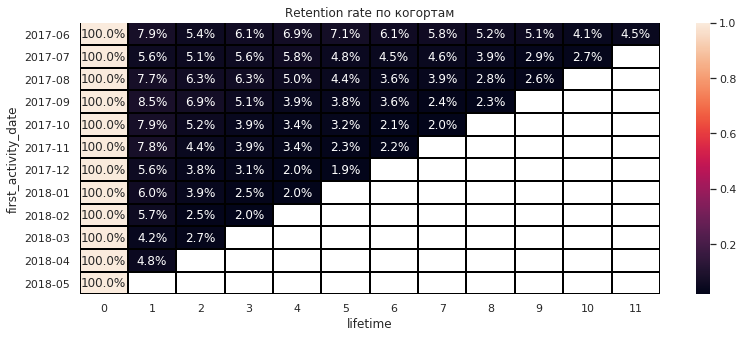

In [175]:
sns.set(style='white')
plt.figure(figsize=(13, 5))
plt.title('Retention rate по когортам')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='black');

В каждой когорте число пользователей после первого месяца резко падает. Несмотря на то, что пользователей в каждой новой когорте приходит достаточно много, потом их численность идет на спад. Небольшой подъем наблюдался лишь у когорты 2017-06 на 6ом месяце и у когорты 2017-07 на 4ом месяце, но и потом число пользователей стало уменьшаться.

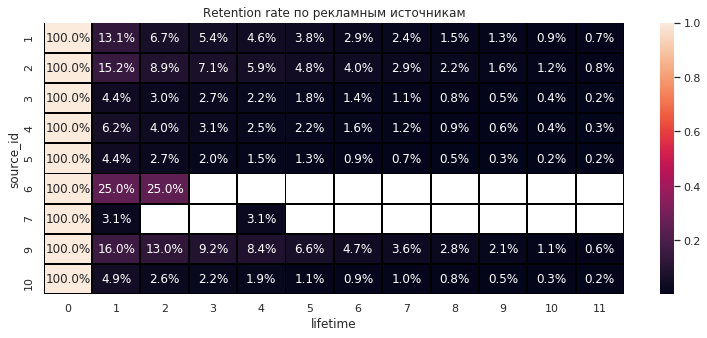

In [176]:
cohorts_source = customer.groupby(['source_id','lifetime']).agg({'uid':'nunique'}).reset_index()

first_uid_count_s = cohorts_source[cohorts_source['lifetime'] == 0][['source_id','uid']]
first_uid_count_s = first_uid_count_s.rename(columns={'uid':'cohort_uid'})
cohorts_source = cohorts_source.merge(first_uid_count_s,on='source_id')
cohorts_source['retention'] = cohorts_source['uid']/cohorts_source['cohort_uid']
retention_pivot_source = cohorts_source.pivot_table(index='source_id',columns='lifetime',values='retention',aggfunc='sum')

sns.set(style='white')
plt.figure(figsize=(13, 5))
plt.title('Retention rate по рекламным источникам')
sns.heatmap(retention_pivot_source, annot=True, fmt='.1%', linewidths=1, linecolor='black')

По каждому рекламному источнику число пользователей после первого месяца резко падает. Несмотря на то, что пользователей в каждой новой когорте приходит достаточно много, процент удержания идет на спад. Самый максимальный Retention rate у рекламных источниках 1 и 2. По рекламному источнику 6 процент удержания довольно высок по сравнению с другими источниками первые 3 месяца, но потом данные пользователи совсем перестают посещать сайт. По рекламному источнику 7 процент удержания очень мал, пользователи посещают сайт редко, а на 6ом месяце данные пользователи совсем перестают заходить на сайт.

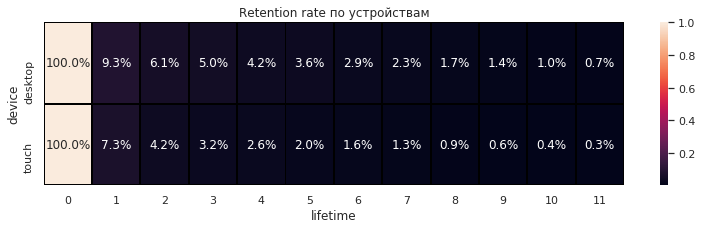

In [177]:
cohorts_device = customer.groupby(['device','lifetime']).agg({'uid':'count'}).reset_index()
first_uid_count_d = cohorts_device[cohorts_device['lifetime']==0][['device','uid']]
first_uid_count_d = first_uid_count_d.rename(columns={'uid':'cohort_uid'})
cohorts_device = cohorts_device.merge(first_uid_count_d,on='device',how='left')
cohorts_device['retention'] = cohorts_device['uid']/cohorts_device['cohort_uid']
retention_pivot_device = cohorts_device.pivot_table(index='device',columns='lifetime',values='retention',aggfunc='sum')

sns.set(style='white')
plt.figure(figsize=(13, 3))
plt.title('Retention rate по устройствам')
sns.heatmap(retention_pivot_device, annot=True, fmt='.1%', linewidths=1, linecolor='black');

По каждому устройству число пользователей после первого месяца резко падает. Несмотря на то, что пользователей изначально приходит достаточно много, процент удержания идет на спад. Процент удержания Retention rate пользователей, использующих компьютеры больше, чем у пользователей, использующихтелефоны/планшеты. 

### Продажи <a id='sale'></a>

#### Когда люди начинают покупать?

Рассмотрим данные о заказах.

In [178]:
orders.head()

,buy_ts,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [179]:
orders[orders['revenue']==0].head()

,buy_ts,revenue,uid
1802,2017-06-22 18:19:00,0.0,17030528792926543083
2787,2017-07-07 15:54:00,0.0,10281425020415612933
4783,2017-08-02 14:54:00,0.0,184148767273119549
5095,2017-08-09 14:48:00,0.0,5603453646174104178
5863,2017-08-23 13:43:00,0.0,5603453646174104178


Удалим из дальнейшего анализа строки с нулевой выручкой. Так как эти "заказы" не приносят прибыль, т.е. пользователь не совершил покупку.

In [180]:
orders = orders[orders['revenue']!=0]

In [181]:
first_buy_time = orders.groupby('uid')['buy_ts'].min() #  определение времени первой покупки для каждого покупателя
first_buy_time.name = 'first_buy_time'

In [182]:
# группируем данные по уникальным пользователям и оставляем данные о времени первого посещения,
# об устройстве и рекламном источнике, с которых впервые зашел пользователь
buyers = visits.groupby('uid').agg({'start_ts':'first','source_id':'first','device':'first'})
buyers.head()

,start_ts,source_id,device
uid,,,
11863502262781,2018-03-01 17:27:00,3,touch
49537067089222,2018-02-06 15:55:00,2,touch
297729379853735,2017-06-07 18:47:00,3,desktop
313578113262317,2018-03-11 17:23:00,2,desktop
325320750514679,2017-09-30 14:29:00,5,desktop


Чтобы определить когда пользователи начинают покупать, объединим датафреймы first_buy_time и buyers по покупателям, которые есть во втором датафрейме, так как они совершили покупки.

In [183]:
buyers = buyers.merge(first_buy_time,on='uid',how='right') #  объединение таблиц
buyers.head()

,start_ts,source_id,device,first_buy_time
uid,,,,
313578113262317,2018-03-11 17:23:00,2,desktop,2018-01-03 21:51:00
1575281904278712,2017-06-03 10:13:00,10,touch,2017-06-03 10:13:00
2429014661409475,2017-10-11 17:14:00,3,desktop,2017-10-11 18:33:00
2464366381792757,2018-01-27 20:10:00,5,desktop,2018-01-28 15:54:00
2551852515556206,2017-11-24 11:22:00,5,desktop,2017-11-24 10:14:00


Определим время в минутах от момента первого посещения сайта до покупки.

In [184]:
buyers['time_before_buy'] = ((buyers['first_buy_time'] - buyers['start_ts']).dt.seconds)/60 # выражаем время в минутах
buyers.head()

,start_ts,source_id,device,first_buy_time,time_before_buy
uid,,,,,
313578113262317,2018-03-11 17:23:00,2,desktop,2018-01-03 21:51:00,268.0
1575281904278712,2017-06-03 10:13:00,10,touch,2017-06-03 10:13:00,0.0
2429014661409475,2017-10-11 17:14:00,3,desktop,2017-10-11 18:33:00,79.0
2464366381792757,2018-01-27 20:10:00,5,desktop,2018-01-28 15:54:00,1184.0
2551852515556206,2017-11-24 11:22:00,5,desktop,2017-11-24 10:14:00,1372.0


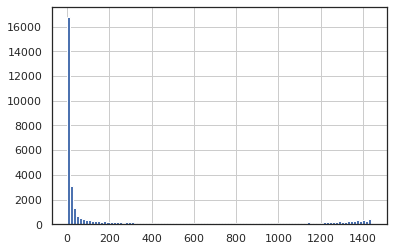

In [185]:
buyers['time_before_buy'].hist(bins=100)
plt.show()

In [186]:
buyers['time_before_buy'].describe()

count    36508.00000
mean       306.45716
std        475.99745
min          0.00000
25%          4.00000
50%         19.00000
75%        454.00000
max       1439.00000
Name: time_before_buy, dtype: float64

In [187]:
buyers['time_before_buy'].mode()

0    1.0
dtype: float64

По гистограмме видно, что имеется большой пик в нуле. Об этом стоит сообщить разработчикам, так как возможно это баг(пользователь не может прийти на сайт и в одну секунду оплатить заказ). Гистограмма не похожа на нормальное распределение, есть много значений до 300 мин., и потом идут значения от 1200 мин. Среднее значение времени от первого посещения до покупки 306 минут, сильно отличается от медианного значения 19 минут, а наиболее часто встречаемое время 1 минута.

Построим диаграммы размаха для отображения длительности времени от посещения сайта до покупки (мин.)

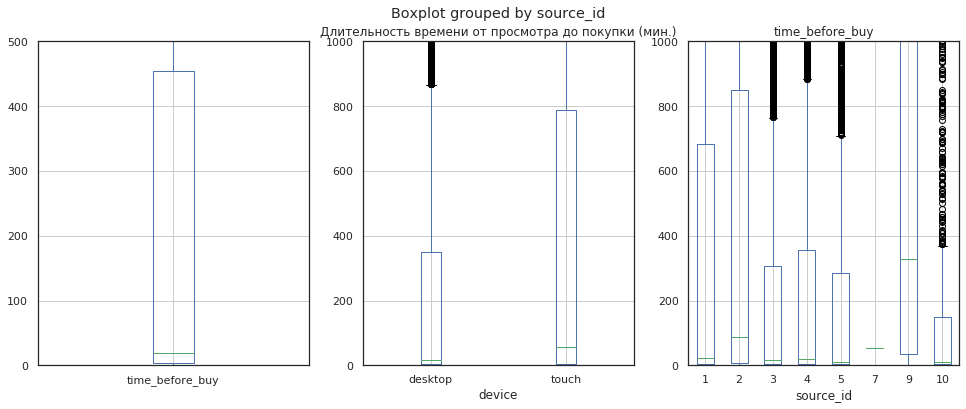

In [188]:
plt.subplots(figsize=(16,6))
buyers.boxplot('time_before_buy',ax=plt.subplot(1,3,1))
plt.ylim(0,500)
buyers.boxplot('time_before_buy',by='device',ax=plt.subplot(1,3,2))
plt.ylim(0,1000)
plt.title('Длительность времени от просмотра до покупки (мин.)')
buyers.boxplot('time_before_buy',by='source_id',ax=plt.subplot(1,3,3))
plt.ylim(0,1000)
plt.show()

Пользователи, использующие компьютер быстрее делают покупки, чем пользователи с телефонов/планшетов. Пользователи, пришедшие из рекламных источников 10,3,4,5 быстрее остальных делают покупки. Пользователи из рекламного источника 6 вообще не совершают покупок, а самое долгое время между посещением сайта и покупкой у пользователей, пришедших из источника 9.

#### Сколько раз покупают за период?

Воспользуемся сформированной выше таблицей buyers.
(cгруппировали данные по уникальным пользователям и оставляем данные о времени первого посещения,  об устройстве и рекламном источнике, с которых впервые зашел пользователь)
 buyers = visits.groupby('uid').agg({'start_ts':'first','source_id':'first','device':'first'})

In [189]:
buyers.head()

,start_ts,source_id,device,first_buy_time,time_before_buy
uid,,,,,
313578113262317,2018-03-11 17:23:00,2,desktop,2018-01-03 21:51:00,268.0
1575281904278712,2017-06-03 10:13:00,10,touch,2017-06-03 10:13:00,0.0
2429014661409475,2017-10-11 17:14:00,3,desktop,2017-10-11 18:33:00,79.0
2464366381792757,2018-01-27 20:10:00,5,desktop,2018-01-28 15:54:00,1184.0
2551852515556206,2017-11-24 11:22:00,5,desktop,2017-11-24 10:14:00,1372.0


Присоединим к таблице orders данные по каждому пользователю из таблицы buyers.

In [190]:
orders_count = orders.merge(buyers[['start_ts','source_id','device','first_buy_time']],on='uid',how='left')
orders_count.sample(10)

,buy_ts,revenue,uid,start_ts,source_id,device,first_buy_time
3514,2017-07-15 17:50:00,9.78,7328681221535233123,2017-07-15 17:45:00,4,touch,2017-07-15 17:50:00
49907,2018-05-31 10:36:00,4.40,14343376689001970351,2018-05-31 10:06:00,2,touch,2018-05-31 10:36:00
20699,2017-11-28 15:50:00,16.47,17870581866064122636,2017-12-05 17:45:00,2,desktop,2017-11-24 11:15:00
1778,2017-06-22 13:22:00,1.65,3304776647522269813,2017-06-22 13:19:00,10,touch,2017-06-22 13:22:00
33014,2018-02-05 15:23:00,3.05,10343016064897450067,2017-12-19 18:40:00,2,desktop,2017-12-07 13:58:00
49702,2018-05-30 20:01:00,1.83,147579374213368924,2017-10-13 23:45:00,2,touch,2017-10-13 23:46:00
17277,2017-11-13 13:34:00,3.67,4361751513674374928,2017-11-13 13:33:00,4,desktop,2017-11-13 13:34:00
21116,2017-11-30 15:41:00,1.22,9071901756869825743,2017-12-07 19:15:00,5,desktop,2017-11-30 14:28:00
14310,2017-10-24 12:58:00,3.05,3601099419845979773,2017-08-20 15:08:00,2,desktop,2017-07-26 08:17:00
33159,2018-02-06 11:52:00,1.22,8423997807421639486,2017-11-20 13:22:00,5,desktop,2017-11-23 12:15:00


Чтобы посчитать ежедневные, недельные и месячные закзы, выделим в отдельные столбцы месяц и неделю, а также полную дату.

In [191]:
orders_count['buy_ts_day'] = orders_count['buy_ts'].astype('datetime64[D]') #размерность временной сетки - день
orders_count['buy_ts_month'] = orders_count['buy_ts'].astype('datetime64[M]') #размерность временной сетки - месяц

Построим графики количества покупок в день в общем, по устройствам и рекламным источникам.

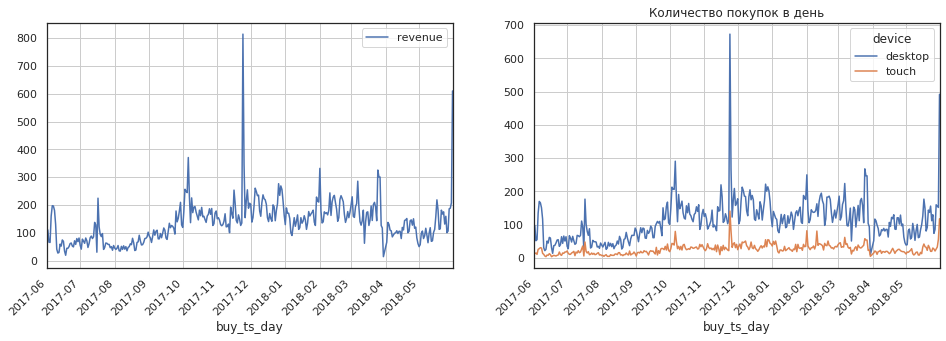

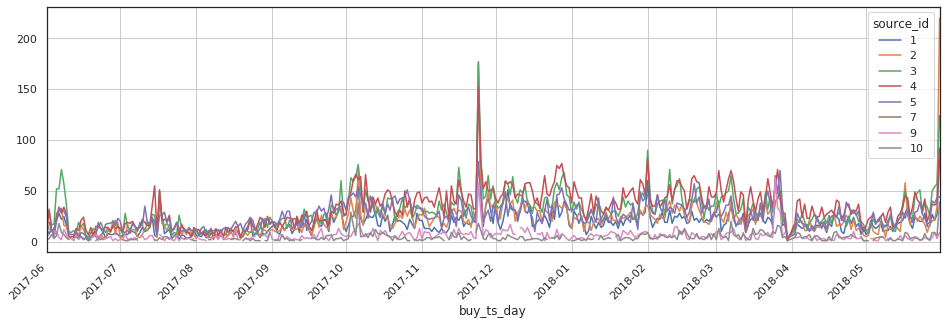

In [192]:
plt.subplots(figsize=(16,5))

orders_count.groupby('buy_ts_day').agg({'revenue':'count'}).plot(grid=True,rot=45,ax=plt.subplot(1,2,1))
pd.pivot_table(orders_count,
              index='buy_ts_day',
               columns='device',
               values='revenue',
               aggfunc='count').plot(grid=True,rot=45,ax=plt.subplot(1,2,2))
plt.title('Количество покупок в день')
pd.pivot_table(orders_count,
              index='buy_ts_day',
               columns='source_id',
               values='revenue',
               aggfunc='count').plot(grid=True,rot=45,figsize=(16,5)) 

plt.show()


Построим графики количества покупок в месяц в общем, по устройствам и рекламным источникам.

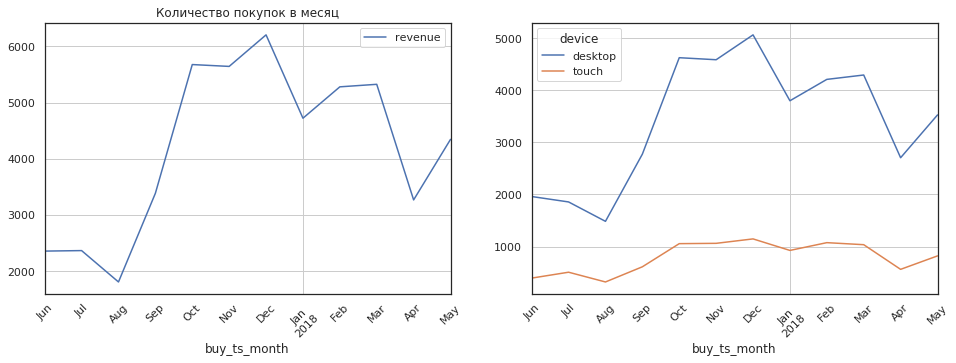

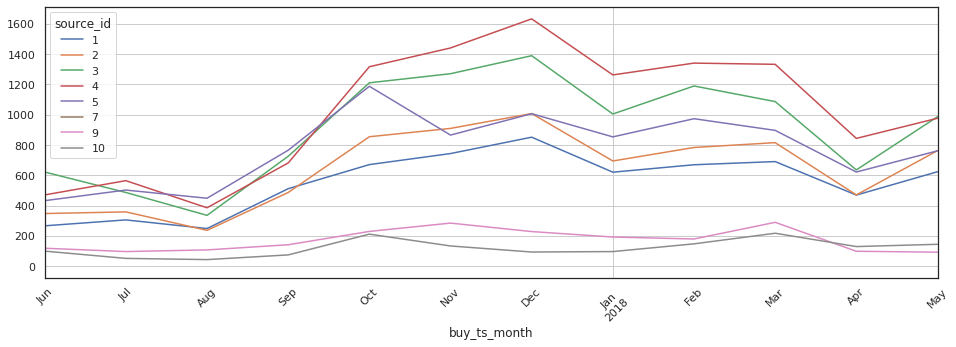

In [193]:
plt.subplots(figsize=(16,5))

orders_count.groupby('buy_ts_month').agg({'revenue':'count'}).plot(grid=True,rot=45,ax=plt.subplot(1,2,1))
plt.title('Количество покупок в месяц')
pd.pivot_table(orders_count,
              index='buy_ts_month',
               columns='device',
               values='revenue',
               aggfunc='count').plot(grid=True,rot=45,ax=plt.subplot(1,2,2))
pd.pivot_table(orders_count,
              index='buy_ts_month',
               columns='source_id',
               values='revenue',
               aggfunc='count').plot(grid=True,rot=45,figsize=(16,5)) 

plt.show()

Итак,  меньшее количество заказов было в июне-августе 2017г, а наибольшее в 4-ом квартале 2017г. Число покупателей, заходящих на сайт с компьютера,значительно превышает число пользователей,покупателей с телефона/планшета. Из рассматриваемых источников рекламы 1,2,3,4,5,7,9,10 в основном покупатели из 3,4 и 5го, очень мало покупателей, пришедших из 9,10 источников. Данный вывод одинаков для ежедневного, еженедельного и месячного анализа.

#### Средний чек

Воспользуемся сформированной выше таблицей orders_count.

In [194]:
orders_count.head()

,buy_ts,revenue,uid,start_ts,source_id,device,first_buy_time,buy_ts_day,buy_ts_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:09:00,1,desktop,2017-06-01 00:10:00,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:14:00,2,desktop,2017-06-01 00:25:00,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:25:00,2,desktop,2017-06-01 00:27:00,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:14:00,2,desktop,2017-06-01 00:29:00,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:31:00,3,desktop,2017-06-01 07:58:00,2017-06-01,2017-06-01


In [195]:
purchaser  = orders_count

Создадим новый столбцы с месяцем заказа и месяцем первой покупки для каждого покупателя.

In [196]:
purchaser['buy_ts_month'] = purchaser['buy_ts'].astype('datetime64[M]')
purchaser['first_buy_month'] = purchaser['first_buy_time'].astype('datetime64[M]')

 Сгруппируем данные по столбцу first_buy_month и определим среднюю выручку по каждой когорты. 

In [197]:
cohort_grouped = purchaser.groupby('first_buy_month').agg({'uid':'nunique','revenue':'sum'})
cohort_grouped['rev_uid'] = cohort_grouped['revenue'] / cohort_grouped['uid']
cohort_grouped

,uid,revenue,rev_uid
first_buy_month,,,
2017-06-01,2022,24030.25,11.884397
2017-07-01,1922,16127.92,8.391217
2017-08-01,1369,11606.26,8.477911
2017-09-01,2579,34672.72,13.444250
2017-10-01,4340,27603.45,6.360242
2017-11-01,4078,26098.77,6.399895
2017-12-01,4380,33490.11,7.646144
2018-01-01,3373,16663.13,4.940151
2018-02-01,3651,16750.50,4.587921


Наибольшая средняя выручка у покупателей когорт 2017-06 и 2017-09-01. Хотя делать выводы о 'новых' когортах не совсем уместно при таком анализе, так как количество месяцев пользования сайтом различно для разных когорт. Поэтому необходимо рассмотреть как изменяется средний чек в зависимости от времени. 


Сгруппируем данные по столбцу first_buy_month и определим среднюю выручку по каждому рекламному источнику. 

In [198]:
cohort_grouped_s = purchaser.groupby('source_id').agg({'uid':'nunique','revenue':'sum'})
cohort_grouped_s['rev_uid'] = cohort_grouped_s['revenue'] / cohort_grouped_s['uid']
cohort_grouped_s

,uid,revenue,rev_uid
source_id,,,
1,3740,38560.06,10.310176
2,4319,65146.76,15.083760
3,9135,44323.18,4.852018
4,9821,52476.33,5.343278
5,6838,40357.91,5.902005
7,1,1.22,1.220000
9,1415,7076.98,5.001399
10,1239,4111.34,3.318273


Средняя выручка покупателей, пришедших из рекламных источников 1,2 максимальная; из рекламного источника 7 совершена всего одна покупка.

Сгруппируем данные по столбцу first_buy_month и определим среднюю выручку по типу устройства. 

In [199]:
cohort_grouped_d = purchaser.groupby('device').agg({'uid':'nunique','revenue':'sum'})
cohort_grouped_d['rev_uid'] = cohort_grouped_d['revenue'] / cohort_grouped_d['uid']
cohort_grouped_d

,uid,revenue,rev_uid
device,,,
desktop,29207,211523.75,7.242228
touch,7301,40530.03,5.551298


Средняя выручка от покупателей, использующих компьютер, больше, чем средняя выручка от покупателей, использующих телефон/планшет.

Рассмотрим как с течением времени изменяется средний чек — сумма покупок, делённая на число покупателей. Так узнаем, увеличивается или уменьшается средний чек покупателей, которые продолжают делать заказы в магазине.

In [200]:
# сгруппируем данные по когорте и месяцу совершения заказа.
purchaser_by_cohorts =  (purchaser.groupby(['first_buy_month','buy_ts_month'])
                              .agg({'uid':'nunique','revenue':'sum'}).reset_index()
                             )
purchaser_by_cohorts.sample(3)

,first_buy_month,buy_ts_month,uid,revenue
15,2017-07-01,2017-10-01,64,690.31
37,2017-09-01,2018-01-01,52,1033.84
71,2018-02-01,2018-05-01,39,270.70


Найдём средний чек покупателя revenue_uid разделим показатель revenue на uid:

In [201]:
purchaser_by_cohorts['revenue_uid'] = purchaser_by_cohorts['revenue'] / purchaser_by_cohorts['uid']

Построим сводную таблицу изменения среднего чека в когортах по месяцу совершения покупки и оценим, как изменяется средний чек с течением времени:

In [202]:
purchaser_by_cohorts.pivot_table(index='first_buy_month',columns='buy_ts_month',values='revenue_uid',aggfunc='mean').fillna('')

buy_ts_month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01
first_buy_month,,,,,,,,,,,,
2017-06-01,4.72675,16.0954,17.7068,35.7648,23.7768,22.2078,31.4967,25.0332,19.2957,27.2336,25.6813,9.804151
2017-07-01,,6.01335,12.3963,21.036,10.7861,6.93816,7.89684,6.42111,6.99282,7.38214,12.8618,11.513846
2017-08-01,,,5.28037,11.1488,11.8513,12.183,16.9212,12.1391,9.62033,12.6105,21.07,8.307419
2017-09-01,,,,5.64891,22.3604,13.5446,138.669,19.8815,26.095,27.4371,16.9614,11.044651
2017-10-01,,,,,5.00373,11.2874,6.75325,7.41315,7.0728,7.25514,6.57321,7.479701
2017-11-01,,,,,,5.15936,7.359,6.78658,12.5107,7.53938,4.58083,7.564839
2017-12-01,,,,,,,4.74243,7.81658,39.366,48.1351,27.4314,23.518413
2018-01-01,,,,,,,,4.13564,8.72123,12.3655,11.1998,4.699556
2018-02-01,,,,,,,,,4.15699,8.61,4.94241,6.941026


Оценим, как изменяется средний чек в зависимости от времени, прошедшего с момента первой покупки. Найдём lifetime когорты. Из месяца совершения заказа вычтем месяц когорты.

In [203]:
purchaser_by_cohorts = purchaser_by_cohorts.reset_index() # сбросим мультииндекс

In [204]:
purchaser_by_cohorts['cohort_lifetime'] = ((purchaser_by_cohorts['buy_ts_month'] - purchaser_by_cohorts['first_buy_month'])/np.timedelta64(1, 'M')).round().astype('int')

Применим метод dt.strftime()  — он превращает объект Series с типом datetime в строку в формате даты. Оставим в данных о месяце первого заказа только год и месяц.

In [205]:
purchaser_by_cohorts['first_buy_month'] = purchaser_by_cohorts['first_buy_month'].dt.strftime('%Y-%m')

In [206]:
purchaser_by_cohorts.head()

,index,first_buy_month,buy_ts_month,uid,revenue,revenue_uid,cohort_lifetime
0,0,2017-06,2017-06-01,2022,9557.49,4.726751,0
1,1,2017-06,2017-07-01,61,981.82,16.095410,1
2,2,2017-06,2017-08-01,50,885.34,17.706800,2
3,3,2017-06,2017-09-01,54,1931.30,35.764815,3
4,4,2017-06,2017-10-01,87,2068.58,23.776782,4


Построим сводную таблицу изменения среднего чека, где в столбцах будет lifetime, а строках — когорты.

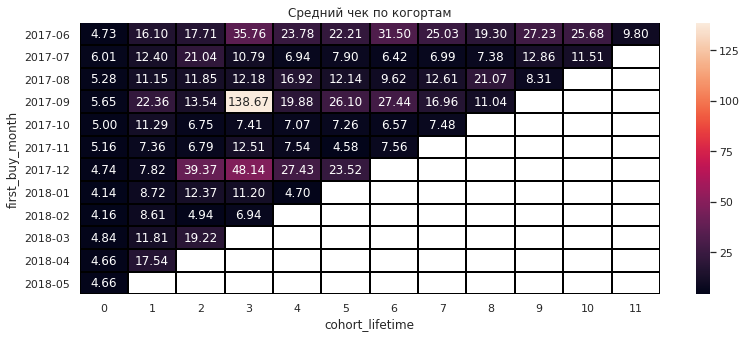

In [207]:
revenue_uid_pivot = purchaser_by_cohorts.pivot_table(index='first_buy_month',columns='cohort_lifetime',values='revenue_uid',aggfunc='mean')
revenue_uid_pivot

sns.set(style='white')
plt.figure(figsize=(13, 5))
plt.title('Средний чек по когортам')
sns.heatmap(revenue_uid_pivot, annot=True, fmt='.2f', linewidths=1, linecolor='black')

plt.show()

Заметим, что средний чек второго месяца всегда больше, чем первого. В основном, самым прибыльными месяцами являются 3,4,5 месяцы каждой когорты. У когорт 2017-06, 2017-09 и 2017-12 самый большой средний чек.

#### Сколько денег приносят? (LTV)

С точки зрения когортного анализа LTV — накопительная выручка когорты в пересчёте на количество людей. 

Воспользуемся сформированной выше таблицей purchaser.

(  purchaser= orders.merge(buyers[['start_ts','source_id','device','first_buy_time']],on='uid',how='left')
  buyers = visits.groupby('uid').agg({'start_ts':'first','source_id':'first','device':'first'})
  )

In [208]:
purchaser.head()

,buy_ts,revenue,uid,start_ts,source_id,device,first_buy_time,buy_ts_day,buy_ts_month,first_buy_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:09:00,1,desktop,2017-06-01 00:10:00,2017-06-01,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:14:00,2,desktop,2017-06-01 00:25:00,2017-06-01,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:25:00,2,desktop,2017-06-01 00:27:00,2017-06-01,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:14:00,2,desktop,2017-06-01 00:29:00,2017-06-01,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:31:00,3,desktop,2017-06-01 07:58:00,2017-06-01,2017-06-01,2017-06-01


In [209]:
# сгруппируем данные по когорте,месяцу совершения заказа,рекламному источнику и типу устройства.
purchaser_ltv = (purchaser.groupby(['first_buy_month','buy_ts_month','source_id','device'])
                              .agg({'revenue':'sum'}).reset_index()
                             )
purchaser_ltv.sample(5)

,first_buy_month,buy_ts_month,source_id,device,revenue
107,2017-06-01,2018-04-01,1,desktop,605.86
640,2017-12-01,2017-12-01,2,desktop,3328.71
507,2017-10-01,2018-02-01,3,desktop,122.06
22,2017-06-01,2017-07-01,5,touch,1.22
715,2018-01-01,2018-01-01,3,touch,677.95


Найдём lifetime когорты. Из месяца совершения заказа вычтем месяц первой покупки.

In [210]:
purchaser_ltv['lifetime'] =(
    ((purchaser_ltv['buy_ts_month'] - purchaser_ltv['first_buy_month'])
     /np.timedelta64(1, 'M')).round().astype('int')
)

Посчитаем количество новых покупателей в каждой когорте n_cohort, в каждом рекламном источнике n_source_id, в каждом типе устройств n_device.

In [211]:
cohort_n = purchaser.groupby('first_buy_month')['uid'].nunique().reset_index()
cohort_n.columns = ['first_buy_month', 'n_cohort']

print(cohort_n.head())

  first_buy_month  n_cohort
0      2017-06-01      2022
1      2017-07-01      1922
2      2017-08-01      1369
3      2017-09-01      2579
4      2017-10-01      4340


In [212]:
source_id_n = purchaser.groupby('source_id')['uid'].nunique().reset_index()
source_id_n.columns = ['source_id', 'n_source_id']
print(source_id_n)

   source_id  n_source_id
0          1         3740
1          2         4319
2          3         9135
3          4         9821
4          5         6838
5          7            1
6          9         1415
7         10         1239


In [213]:
device_n = purchaser.groupby('device')['uid'].nunique().reset_index()
device_n.columns = ['device', 'n_device']
print(device_n)

    device  n_device
0  desktop     29207
1    touch      7301


Добавим в таблицу purchaser_ltv данные о том, сколько людей первый раз совершили покупку в каждой когорте n_cohort, в каждом рекламном источнике n_source_id, в каждом типе устройств n_device.

In [214]:
purchaser_ltv = purchaser_ltv.merge(cohort_n,on='first_buy_month',how='left')
purchaser_ltv = purchaser_ltv.merge(source_id_n,on='source_id',how='left')
purchaser_ltv = purchaser_ltv.merge(device_n,on='device',how='left')
purchaser_ltv.head()

,first_buy_month,buy_ts_month,source_id,device,revenue,lifetime,n_cohort,n_source_id,n_device
0,2017-06-01,2017-06-01,1,desktop,1035.53,0,2022,3740,29207
1,2017-06-01,2017-06-01,1,touch,132.92,0,2022,3740,7301
2,2017-06-01,2017-06-01,2,desktop,1302.57,0,2022,4319,29207
3,2017-06-01,2017-06-01,2,touch,249.19,0,2022,4319,7301
4,2017-06-01,2017-06-01,3,desktop,2237.20,0,2022,9135,29207


Разделим прибыль когорт за каждый месяц на общее число пользователей в каждой когорте и сохраним в переменной ltv_cohort.
Разделим прибыль по рекламным источникам на начальное число пользователей в источнике и сохраним в переменной ltv_source_id.
Разделим прибыль по устройствам на начальное число пользователей пользователей из этих устройств и сохраним в переменной ltv_device.

In [215]:
purchaser_ltv['ltv_cohort'] = purchaser_ltv['revenue'] / purchaser_ltv['n_cohort'] 
purchaser_ltv['ltv_source_id'] = purchaser_ltv['revenue'] / purchaser_ltv['n_source_id'] 
purchaser_ltv['ltv_device'] = purchaser_ltv['revenue'] / purchaser_ltv['n_device'] 
purchaser_ltv.head()

,first_buy_month,buy_ts_month,source_id,device,revenue,lifetime,n_cohort,n_source_id,n_device,ltv_cohort,ltv_source_id,ltv_device
0,2017-06-01,2017-06-01,1,desktop,1035.53,0,2022,3740,29207,0.512132,0.276880,0.035455
1,2017-06-01,2017-06-01,1,touch,132.92,0,2022,3740,7301,0.065737,0.035540,0.018206
2,2017-06-01,2017-06-01,2,desktop,1302.57,0,2022,4319,29207,0.644199,0.301591,0.044598
3,2017-06-01,2017-06-01,2,touch,249.19,0,2022,4319,7301,0.123239,0.057696,0.034131
4,2017-06-01,2017-06-01,3,desktop,2237.20,0,2022,9135,29207,1.106429,0.244904,0.076598


LTV по когортам.

In [216]:
ltv_pivot = purchaser_ltv.pivot_table(index='first_buy_month', columns='lifetime',values='ltv_cohort',aggfunc='sum').round(2)
ltv_pivot.fillna('')

lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_buy_month,,,,,,,,,,,,
2017-06-01,4.73,0.49,0.44,0.96,1.02,0.74,0.95,0.58,0.55,0.61,0.57,0.26
2017-07-01,6.01,0.34,0.62,0.36,0.18,0.16,0.12,0.14,0.16,0.15,0.16,
2017-08-01,5.28,0.47,0.46,0.39,0.49,0.28,0.21,0.41,0.29,0.19,,
2017-09-01,5.65,1.12,0.52,3.98,0.4,0.65,0.7,0.24,0.18,,,
2017-10-01,5.00,0.54,0.19,0.16,0.15,0.12,0.08,0.12,,,,
2017-11-01,5.16,0.4,0.2,0.33,0.15,0.05,0.12,,,,,
2017-12-01,4.74,0.26,0.93,1.07,0.31,0.34,,,,,,
2018-01-01,4.14,0.29,0.3,0.14,0.06,,,,,,,
2018-02-01,4.16,0.28,0.08,0.07,,,,,,,,


Рассчитываем ltv накопительно по каждой когорте.

In [217]:
ltv_pivot.cumsum(axis=1).fillna('')

lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_buy_month,,,,,,,,,,,,
2017-06-01,4.73,5.22,5.66,6.62,7.64,8.38,9.33,9.91,10.46,11.07,11.64,11.9
2017-07-01,6.01,6.35,6.97,7.33,7.51,7.67,7.79,7.93,8.09,8.24,8.4,
2017-08-01,5.28,5.75,6.21,6.6,7.09,7.37,7.58,7.99,8.28,8.47,,
2017-09-01,5.65,6.77,7.29,11.27,11.67,12.32,13.02,13.26,13.44,,,
2017-10-01,5.00,5.54,5.73,5.89,6.04,6.16,6.24,6.36,,,,
2017-11-01,5.16,5.56,5.76,6.09,6.24,6.29,6.41,,,,,
2017-12-01,4.74,5,5.93,7,7.31,7.65,,,,,,
2018-01-01,4.14,4.43,4.73,4.87,4.93,,,,,,,
2018-02-01,4.16,4.44,4.52,4.59,,,,,,,,


In [218]:
#Найдем среднее ltv для каждого lifetime.

ltv_pivot.cumsum(axis=1)[5].fillna('')

first_buy_month
2017-06-01     8.38
2017-07-01     7.67
2017-08-01     7.37
2017-09-01    12.32
2017-10-01     6.16
2017-11-01     6.29
2017-12-01     7.65
2018-01-01         
2018-02-01         
2018-03-01         
2018-04-01         
2018-05-01         
Name: 5, dtype: object

Наибольшая накопительная выручка у покупателей когорт 2017-09 и 2017-06 (например,рассматривая 6-й месяц). 

LTV по типам устройства.

In [219]:
ltv_pivot_d = purchaser_ltv.pivot_table(index='device', columns='lifetime',values='ltv_device',aggfunc='sum').round(2)
ltv_pivot_d.fillna('')

lifetime,0,1,2,3,4,5,6,7,8,9,10,11
device,,,,,,,,,,,,
desktop,4.89,0.40,0.38,0.70,0.22,0.20,0.17,0.10,0.07,0.06,0.05,0.01
touch,4.72,0.39,0.13,0.06,0.05,0.05,0.03,0.02,0.02,0.02,0.01,0.04


Рассчитываем ltv накопительно по типу устройства.

In [220]:
ltv_pivot_d.cumsum(axis=1).fillna('')

lifetime,0,1,2,3,4,5,6,7,8,9,10,11
device,,,,,,,,,,,,
desktop,4.89,5.29,5.67,6.37,6.59,6.79,6.96,7.06,7.13,7.19,7.24,7.25
touch,4.72,5.11,5.24,5.30,5.35,5.40,5.43,5.45,5.47,5.49,5.50,5.54


Накопительная выручка LTV больше от покупателей, использующих компьютер, чем от покупателей, использующих телефон/планшет.

LTV по рекламным источникам.

In [222]:
ltv_pivot_s = purchaser_ltv.pivot_table(index='source_id', columns='lifetime',values='ltv_source_id',aggfunc='sum').round(2)
ltv_pivot_s.fillna('')

lifetime,0,1,2,3,4,5,6,7,8,9,10,11
source_id,,,,,,,,,,,,
1,6.00,1.02,0.7,0.58,0.35,0.29,0.51,0.24,0.19,0.2,0.2,0.03
2,6.36,1.28,1.31,3.61,0.73,0.79,0.39,0.24,0.15,0.08,0.07,0.06
3,4.37,0.17,0.07,0.08,0.05,0.02,0.04,0.02,0.01,0.01,0,0
4,4.64,0.17,0.11,0.11,0.08,0.06,0.04,0.05,0.03,0.02,0.02,0.01
5,4.75,0.22,0.26,0.15,0.15,0.1,0.08,0.06,0.05,0.04,0.02,0.01
7,1.22,,,,,,,,,,,
9,3.84,0.28,0.2,0.16,0.1,0.07,0.05,0.07,0.16,0.06,0.01,
10,3.13,0.06,0.04,0.03,0.02,0.01,0.01,0.01,0,,,0


Рассчитываем ltv накопительно по рекламным источникам.

In [223]:
ltv_pivot_s.cumsum(axis=1).fillna('')

lifetime,0,1,2,3,4,5,6,7,8,9,10,11
source_id,,,,,,,,,,,,
1,6.00,7.02,7.72,8.3,8.65,8.94,9.45,9.69,9.88,10.08,10.28,10.31
2,6.36,7.64,8.95,12.56,13.29,14.08,14.47,14.71,14.86,14.94,15.01,15.07
3,4.37,4.54,4.61,4.69,4.74,4.76,4.8,4.82,4.83,4.84,4.84,4.84
4,4.64,4.81,4.92,5.03,5.11,5.17,5.21,5.26,5.29,5.31,5.33,5.34
5,4.75,4.97,5.23,5.38,5.53,5.63,5.71,5.77,5.82,5.86,5.88,5.89
7,1.22,,,,,,,,,,,
9,3.84,4.12,4.32,4.48,4.58,4.65,4.7,4.77,4.93,4.99,5,
10,3.13,3.19,3.23,3.26,3.28,3.29,3.3,3.31,3.31,,,3.31


Накопительная сумма LTV, которую покупатели приносят в среднем со всех своих покупок, больше у покупателей, пришедших из рекламных источников 1 и 2. Из рекламного источника 7 покупки совершались лишь в первом месяце. Доходы от рекламных источников 9,10 поступают не в каждом месяце.

### Маркетинг <a id='marketing'></a>

In [225]:
costs.head(3)

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53


Подсчитаем сколько потрачено на рекламу.

In [226]:
print('Всего на рекламу потрачено {:.2f}'.format(costs['costs'].sum()))

Всего на рекламу потрачено 329131.62


In [227]:
# создадим столбец с данными о месяце заказа.
costs['dt_month'] = costs['dt'].astype('datetime64[M]')

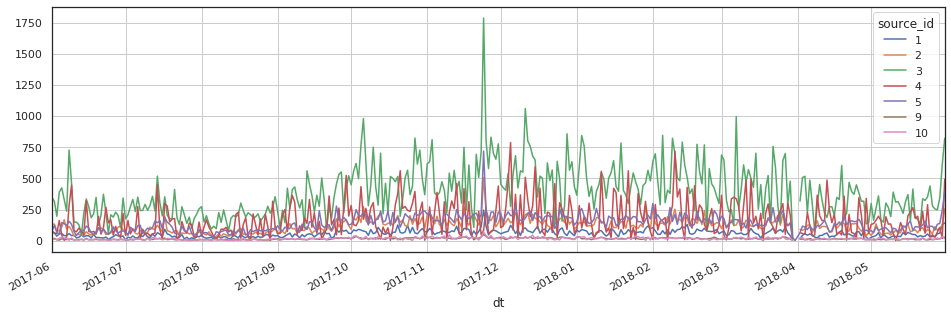

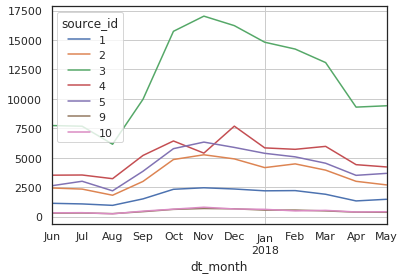

In [228]:
plt.subplots(figsize=(16,5))
pd.pivot_table(costs,
              index='dt',
              columns='source_id',
              values='costs',
              aggfunc='sum').plot(grid=True,ax=plt.subplot(1,1,1))

pd.pivot_table(costs,
              index='dt_month',
              columns='source_id',
              values='costs',
              aggfunc='sum').plot(grid=True)

plt.show()

Больше всего потрачено денег в 4-ом квартале 2017 г., меньше всего затраты на рекламу были в июне-августе 2017г. В основном затраты идут источник рекламы 3, менее на 4,2,5, еще меньше на 1 и 10, и практически нет затрат на источник 9.

#### Сколько стоило привлечение одного покупателя из каждого источника?

Так как необходимо оценить именно покупателей, а не пользователей, то воспользуемся сформированной выше таблицей purchaser.

In [229]:
costs = costs.rename(columns={'dt':'buy_ts_day'}) #переименуем столбец в таблице costs

#Добавим в таблицу purchaser данные о расходах на рекламу по соответствующему источнику
purchaser = purchaser.merge(costs,how='left',on=['source_id','buy_ts_day']) 

purchaser.head()

,buy_ts,revenue,uid,start_ts,source_id,device,first_buy_time,buy_ts_day,buy_ts_month,first_buy_month,costs,dt_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:09:00,1,desktop,2017-06-01 00:10:00,2017-06-01,2017-06-01,2017-06-01,75.20,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:14:00,2,desktop,2017-06-01 00:25:00,2017-06-01,2017-06-01,2017-06-01,132.56,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:25:00,2,desktop,2017-06-01 00:27:00,2017-06-01,2017-06-01,2017-06-01,132.56,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:14:00,2,desktop,2017-06-01 00:29:00,2017-06-01,2017-06-01,2017-06-01,132.56,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:31:00,3,desktop,2017-06-01 07:58:00,2017-06-01,2017-06-01,2017-06-01,349.38,2017-06-01


Сгруппируем данные, чтобы получить расходы на рекламу по источнику и по дате.

In [230]:
purchaser_cost = purchaser.groupby(['source_id','buy_ts_day']).agg({'uid':'count','costs':'mean'})
purchaser_cost.head()

uid  costs
source_id buy_ts_day            
1         2017-06-01   12  75.20
          2017-06-02    8  62.25
          2017-06-03   12  36.53
          2017-06-04    5  55.00
          2017-06-05   21  57.08

Найдем затраты на одного покупателя.

In [231]:
purchaser_cost['uid_cost'] = purchaser_cost['costs'] / purchaser_cost['uid']
purchaser_cost.head()

uid  costs   uid_cost
source_id buy_ts_day                       
1         2017-06-01   12  75.20   6.266667
          2017-06-02    8  62.25   7.781250
          2017-06-03   12  36.53   3.044167
          2017-06-04    5  55.00  11.000000
          2017-06-05   21  57.08   2.718095

In [232]:
purchaser_date = purchaser.copy()
purchaser_date = purchaser_date.reset_index().set_index(['source_id','buy_ts_day'])
purchaser_date.head()

index              buy_ts  revenue  \
source_id buy_ts_day                                       
1         2017-06-01      0 2017-06-01 00:10:00    17.00   
2         2017-06-01      1 2017-06-01 00:25:00     0.55   
          2017-06-01      2 2017-06-01 00:27:00     0.37   
          2017-06-01      3 2017-06-01 00:29:00     0.55   
3         2017-06-01      4 2017-06-01 07:58:00     0.37   

                                       uid            start_ts   device  \
source_id buy_ts_day                                                      
1         2017-06-01  10329302124590727494 2017-06-01 00:09:00  desktop   
2         2017-06-01  11627257723692907447 2017-06-01 00:14:00  desktop   
          2017-06-01  17903680561304213844 2017-06-01 00:25:00  desktop   
          2017-06-01  16109239769442553005 2017-06-01 00:14:00  desktop   
3         2017-06-01  14200605875248379450 2017-06-01 07:31:00  desktop   

                          first_buy_time buy_ts_month first_buy_month   costs  \
source_id buy_ts_day                                                            
1         2017-06-01 2017-06-01 00:10:00   2017-06-01      2017-06-01   75.20   
2         2017-06-01 2017-06-01 00:25:00   2017-06-01      2017-06-01  132.56   
          2017-06-01 2017-06-01 00:27:00   2017-06-01      2017-06-01  132.56   
          2017-06-01 2017-06-01 00:29:00   2017-06-01      2017-06-01  132.56   
3         2017-06-01 2017-06-01 07:58:00   2017-06-01      2017-06-01  349.38   

                       dt_month  
source_id buy_ts_day             
1         2017-06-01 2017-06-01  
2         2017-06-01 2017-06-01  
          2017-06-01 2017-06-01  
          2017-06-01 2017-06-01  
3         2017-06-01 2017-06-01

Добавим полученные данные о затратах на одного покупателя в таблицу purchaser_date.

In [233]:
purchaser_date = purchaser_date.join(purchaser_cost[['uid_cost']],how='left').reset_index()

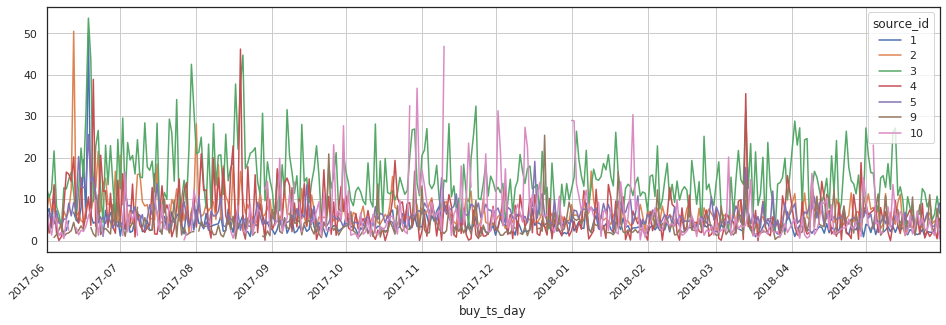

In [234]:
plt.subplots(figsize=(16,5))


plt.title('')
pd.pivot_table(purchaser_date,
              index='buy_ts_day',
               columns='source_id',
               values='uid_cost',
               aggfunc='mean').plot(grid=True,rot=45,ax=plt.subplot(1,1,1))
plt.show()

Отобразим средние расходы на одного пользователя по рекламным источникам в виде таблицы.

In [235]:
pd.pivot_table(purchaser_date,
              index='source_id',
              values='uid_cost',
              aggfunc='mean')


,uid_cost
source_id,
1,3.122519
2,5.544106
3,12.922607
4,4.989266
5,5.559824
9,2.618446
10,3.768114


Привлечение покупателя из рекламного источника 3 самое дорогое, гораздо дешевле обходится привлечение из источников 2,5,4,1,10. Меньше всего трат на 9-й источник. Затрат на 6 и 7 источники нет.

Рассмотрим сколько стоило привлечение одного покупателя из каждого источника с разбивкой по месяцам.

In [236]:
purchaser.head()

,buy_ts,revenue,uid,start_ts,source_id,device,first_buy_time,buy_ts_day,buy_ts_month,first_buy_month,costs,dt_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:09:00,1,desktop,2017-06-01 00:10:00,2017-06-01,2017-06-01,2017-06-01,75.20,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:14:00,2,desktop,2017-06-01 00:25:00,2017-06-01,2017-06-01,2017-06-01,132.56,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:25:00,2,desktop,2017-06-01 00:27:00,2017-06-01,2017-06-01,2017-06-01,132.56,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:14:00,2,desktop,2017-06-01 00:29:00,2017-06-01,2017-06-01,2017-06-01,132.56,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:31:00,3,desktop,2017-06-01 07:58:00,2017-06-01,2017-06-01,2017-06-01,349.38,2017-06-01


Проделаем аналогичный анализ, что и для определения ежедневного привлечения одного покупателя из каждого источника.

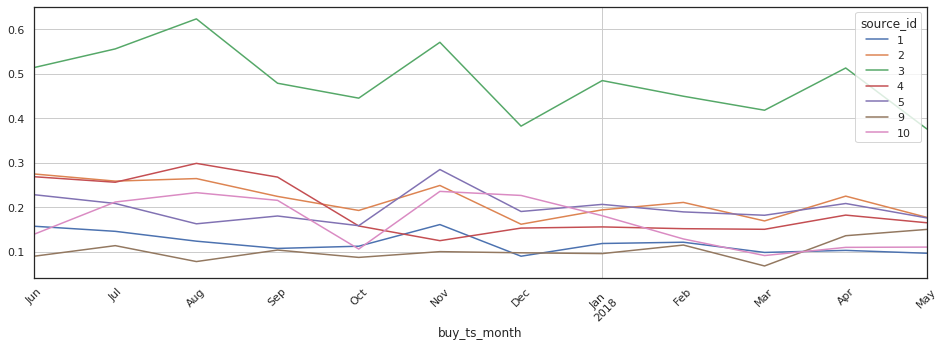

In [237]:
purchaser_cost_m = purchaser.groupby(['source_id','buy_ts_month']).agg({'uid':'count','costs':'mean'})
purchaser_cost_m['uid_cost'] = purchaser_cost_m['costs'] / purchaser_cost_m['uid']
purchaser_month = purchaser.copy()
purchaser_month = purchaser_month.reset_index().set_index(['source_id','buy_ts_month'])
purchaser_month = purchaser_month.join(purchaser_cost_m[['uid_cost']],how='left').reset_index()

plt.subplots(figsize=(16,5))


plt.title('')
pd.pivot_table(purchaser_month,
              index='buy_ts_month',
               columns='source_id',
               values='uid_cost',
               aggfunc='mean').plot(grid=True,rot=45,ax=plt.subplot(1,1,1))

plt.show()


Привлечение покупателя из рекламного источника 3 самое дорогое, гораздо дешевле обходится привлечение из источников 2,5,4,1,10. Меньше всего трат на 9-й источник. Затрат на 6 и 7 источники нет.

#### На сколько окупились расходы? (ROI)

Метрика — ROI (возврат на инвестиции) показывает окупились ли вложения бизнеса. Возврат на инвестиции считают не только для целого бизнеса, но и для его составляющих. В исходных данных имеется только информация о затратах на рекламные источники (costs), поэтому в условиях задачи будем искать окупаемостью маркетинга ROMI (возврат на маркетинговые инвестиции). ROMI рекламной кампании = валовая прибыль из этой кампании / затраты. Поэтому чтобы рассчитать ROMI: поделим LTV на CAC. CAC - стоимость привлечения клиента, т.е. сумма денег, во сколько обходится новый клиент компании. 
CAC для когорты представляет собой частное от расходов за этот месяц, поделенное на количество людей в когорте.
 

Воспользуемся таблицами, сформированными выше.

In [238]:
purchaser_ltv.head()

,first_buy_month,buy_ts_month,source_id,device,revenue,lifetime,n_cohort,n_source_id,n_device,ltv_cohort,ltv_source_id,ltv_device
0,2017-06-01,2017-06-01,1,desktop,1035.53,0,2022,3740,29207,0.512132,0.276880,0.035455
1,2017-06-01,2017-06-01,1,touch,132.92,0,2022,3740,7301,0.065737,0.035540,0.018206
2,2017-06-01,2017-06-01,2,desktop,1302.57,0,2022,4319,29207,0.644199,0.301591,0.044598
3,2017-06-01,2017-06-01,2,touch,249.19,0,2022,4319,7301,0.123239,0.057696,0.034131
4,2017-06-01,2017-06-01,3,desktop,2237.20,0,2022,9135,29207,1.106429,0.244904,0.076598


###### ROMI по месячным когортам.

In [239]:
costs_month_cohort = (
    costs.groupby(['dt_month'])['costs'].sum() 
    .reset_index()
    .rename(columns={'dt_month':'first_buy_month'})
)
costs_month_cohort.head(3)

,first_buy_month,costs
0,2017-06-01,18015.00
1,2017-07-01,18240.59
2,2017-08-01,14790.54


In [240]:
# добавим помесячные расходы в таблицу данных purchaser_ltv, сформировав новый датафрейм
romi_cohort = pd.merge(purchaser_ltv,costs_month_cohort,on=['first_buy_month']) 
romi_cohort.head()

,first_buy_month,buy_ts_month,source_id,device,revenue,lifetime,n_cohort,n_source_id,n_device,ltv_cohort,ltv_source_id,ltv_device,costs
0,2017-06-01,2017-06-01,1,desktop,1035.53,0,2022,3740,29207,0.512132,0.276880,0.035455,18015.0
1,2017-06-01,2017-06-01,1,touch,132.92,0,2022,3740,7301,0.065737,0.035540,0.018206,18015.0
2,2017-06-01,2017-06-01,2,desktop,1302.57,0,2022,4319,29207,0.644199,0.301591,0.044598,18015.0
3,2017-06-01,2017-06-01,2,touch,249.19,0,2022,4319,7301,0.123239,0.057696,0.034131,18015.0
4,2017-06-01,2017-06-01,3,desktop,2237.20,0,2022,9135,29207,1.106429,0.244904,0.076598,18015.0


Найдем для каждой когорты CAC, ROMI
Выведим на экран сводную таблицу с отчётом. В строках — месяц когорты, в столбцах — возраст когорты, в значениях — ROMI. 

In [241]:
romi_cohort['cac_cohort'] = romi_cohort['costs'] / romi_cohort['n_cohort']
romi_cohort['romi_cohort'] = romi_cohort['ltv_cohort']  / romi_cohort['cac_cohort'] 
result_cohort = romi_cohort.pivot_table(index='first_buy_month',columns='lifetime',values='romi_cohort',aggfunc='sum')
result_cohort.fillna('')

lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_buy_month,,,,,,,,,,,,
2017-06-01,0.530530,0.0545001,0.0491446,0.107205,0.114825,0.0825934,0.10665,0.06531,0.0621232,0.0680272,0.0641499,0.0288437
2017-07-01,0.633623,0.0353393,0.0657353,0.0378447,0.0186381,0.0164512,0.0126728,0.0149513,0.0169978,0.0155127,0.0164117,
2017-08-01,0.488747,0.0437192,0.0424677,0.0362428,0.0457624,0.0262634,0.0195131,0.0375145,0.0270666,0.0174118,,
2017-09-01,0.597833,0.118368,0.0550259,0.421091,0.0424245,0.0685332,0.0743098,0.0257529,0.0194888,,,
2017-10-01,0.597866,0.064015,0.0228685,0.0187763,0.018109,0.0143813,0.0101341,0.0137968,,,,
2017-11-01,0.555026,0.0429024,0.0214834,0.034983,0.0159109,0.00580038,0.0123726,,,,,
2017-12-01,0.542129,0.0297849,0.105824,0.12186,0.0357969,0.0386701,,,,,,
2018-01-01,0.416173,0.0296618,0.0306201,0.0143679,0.00630935,,,,,,,
2018-02-01,0.463807,0.0310479,0.00876019,0.00827246,,,,,,,,


Выведим на экран сводную таблицу с отчётом. В строках — месяц когорты, в столбцах — возраст когорты, в значениях — накопительный ROMI. 

In [242]:
result_cohort.cumsum(axis=1).round(2).fillna('')

lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_buy_month,,,,,,,,,,,,
2017-06-01,0.53,0.59,0.63,0.74,0.86,0.94,1.05,1.11,1.17,1.24,1.31,1.33
2017-07-01,0.63,0.67,0.73,0.77,0.79,0.81,0.82,0.84,0.85,0.87,0.88,
2017-08-01,0.49,0.53,0.57,0.61,0.66,0.68,0.7,0.74,0.77,0.78,,
2017-09-01,0.60,0.72,0.77,1.19,1.23,1.3,1.38,1.4,1.42,,,
2017-10-01,0.60,0.66,0.68,0.7,0.72,0.74,0.75,0.76,,,,
2017-11-01,0.56,0.6,0.62,0.65,0.67,0.68,0.69,,,,,
2017-12-01,0.54,0.57,0.68,0.8,0.84,0.87,,,,,,
2018-01-01,0.42,0.45,0.48,0.49,0.5,,,,,,,
2018-02-01,0.46,0.49,0.5,0.51,,,,,,,,


Быстрее всего окупаются когорты 2017-06 и 2017-09. 

Рассчитаем среднюю когорту — усредним ROMI или LTV всех когорт за каждый месяц их жизни. Узнаем, как быстро в среднем когорты окупаются. Усредним значения каждой колонки и «сложим» таблицу в единую строку методом mean(axis=0).

In [243]:
result_cohort.cumsum(axis=1).mean(axis=0)

lifetime
0     0.540835
1     0.582000
2     0.631070
3     0.719738
4     0.782942
5     0.859870
6     0.896780
7     0.969905
8     1.053814
9     0.964461
10    1.094618
11    1.333902
dtype: float64

Если ROMI больше 1 то это означает, что затраты окупились на 100%. В среднем когорты окупаются к концу 11-го месяца.

Узнаем, сколько денег могут тратить маркетологи на привлечение одного покупателя, если хотят, чтобы реклама окупилась за 6 месяцев.

In [244]:
final_result = romi_cohort.pivot_table(index='first_buy_month', columns='lifetime', values='ltv_cohort', aggfunc='sum')
# посчитаем накопительный LTV за 6 месяцев после первой покупки
m6_cum_ltv = final_result.mean(axis=0).cumsum()[5].round(2)
print('Средний LTV за 6 месяцев после первой покупки:', m6_cum_ltv)

Средний LTV за 6 месяцев после первой покупки: 7.29


Чтобы вложения в маркетинг окупались,привлечение одного покупателя не должно превышать 7.23

###### ROMI по рекламным истчникам.

Аналогично посчитаем ROMI по рекламным истчникам.

In [245]:
# сгруппируем затраты по рекламным источникам
costs_month_source_id = costs.groupby('source_id')['costs'].sum().reset_index()
costs_month_source_id

,source_id,costs
0,1,20833.27
1,2,42806.04
2,3,141321.63
3,4,61073.60
4,5,51757.10
5,9,5517.49
6,10,5822.49


In [246]:
# добавим полученные затраты в таблицу данных purchaser_ltv, сформировав новый датафрейм
romi_source_id = pd.merge(purchaser_ltv,costs_month_source_id,on='source_id') 
romi_source_id.head()

,first_buy_month,buy_ts_month,source_id,device,revenue,lifetime,n_cohort,n_source_id,n_device,ltv_cohort,ltv_source_id,ltv_device,costs
0,2017-06-01,2017-06-01,1,desktop,1035.53,0,2022,3740,29207,0.512132,0.276880,0.035455,20833.27
1,2017-06-01,2017-06-01,1,touch,132.92,0,2022,3740,7301,0.065737,0.035540,0.018206,20833.27
2,2017-06-01,2017-07-01,1,desktop,287.78,1,2022,3740,29207,0.142324,0.076947,0.009853,20833.27
3,2017-06-01,2017-07-01,1,touch,75.16,1,2022,3740,7301,0.037171,0.020096,0.010294,20833.27
4,2017-06-01,2017-08-01,1,desktop,145.78,2,2022,3740,29207,0.072097,0.038979,0.004991,20833.27


Найдем для каждой когорты CAC, ROMI
Выведим на экран сводную таблицу с отчётом. В строках — месяц когорты, в столбцах — рекламный источник, в значениях — ROMI.

In [247]:
romi_source_id['cac_source_id'] = romi_source_id['costs'] / romi_source_id['n_source_id']
romi_source_id['romi_source_id'] = romi_source_id['ltv_source_id'] / romi_source_id['cac_source_id'] 
result_source_id = romi_source_id.pivot_table(index='first_buy_month',columns='lifetime',values='romi_source_id',aggfunc='sum')
result_source_id.fillna('')

lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_buy_month,,,,,,,,,,,,
2017-06-01,0.274354,0.0343529,0.0229785,0.0611377,0.0644211,0.0532465,0.067813,0.036258,0.0376022,0.0441343,0.0404429,0.0138867
2017-07-01,0.330570,0.0229296,0.0538206,0.0245065,0.0163081,0.0107204,0.00953588,0.00979233,0.0103366,0.00741402,0.0111539,
2017-08-01,0.235765,0.0276242,0.0251231,0.0189162,0.0199897,0.0134974,0.0112182,0.0246434,0.0404986,0.0190224,,
2017-09-01,0.394089,0.0821829,0.0452679,0.251993,0.0295353,0.0392147,0.0586409,0.0206446,0.0152695,,,
2017-10-01,0.628498,0.0694221,0.0261168,0.0211946,0.016489,0.0146633,0.0101369,0.0144066,,,,
2017-11-01,0.621202,0.0396153,0.0271651,0.0360324,0.0155722,0.00720631,0.01068,,,,,
2017-12-01,0.541227,0.0357204,0.100613,0.117499,0.0332435,0.0363948,,,,,,
2018-01-01,0.379650,0.0333,0.0295048,0.017973,0.00643904,,,,,,,
2018-02-01,0.411223,0.0325779,0.0107596,0.00920091,,,,,,,,


Выведим на экран сводную таблицу с отчётом. В строках — месяц когорты, в столбцах — возраст когорты, в значениях — накопительный ROMI. 

In [248]:
result_source_id.cumsum(axis=1).round(2).fillna('')

lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_buy_month,,,,,,,,,,,,
2017-06-01,0.27,0.31,0.33,0.39,0.46,0.51,0.58,0.61,0.65,0.7,0.74,0.75
2017-07-01,0.33,0.35,0.41,0.43,0.45,0.46,0.47,0.48,0.49,0.5,0.51,
2017-08-01,0.24,0.26,0.29,0.31,0.33,0.34,0.35,0.38,0.42,0.44,,
2017-09-01,0.39,0.48,0.52,0.77,0.8,0.84,0.9,0.92,0.94,,,
2017-10-01,0.63,0.7,0.72,0.75,0.76,0.78,0.79,0.8,,,,
2017-11-01,0.62,0.66,0.69,0.72,0.74,0.75,0.76,,,,,
2017-12-01,0.54,0.58,0.68,0.8,0.83,0.86,,,,,,
2018-01-01,0.38,0.41,0.44,0.46,0.47,,,,,,,
2018-02-01,0.41,0.44,0.45,0.46,,,,,,,,


Если ROMI больше 1 то это означает, что затраты окупились на 100%. Быстрее всего окупаются рекламные источники 1,9,2. По данным за год остальные рекламные источники не окупились.

In [249]:
ltv_6_s = ltv_pivot_s.cumsum(axis=1).round(2)[5]
print('LTV за 6 месяцев после первой покупки по рекламным источникам:',ltv_6_s)

LTV за 6 месяцев после первой покупки по рекламным источникам: source_id
1      8.94
2     14.08
3      4.76
4      5.17
5      5.63
7       NaN
9      4.65
10     3.29
Name: 5, dtype: float64


Чтобы вложения в маркетинг окупались,привлечение одного покупателя по рекламным источникам не должно превышать этих начений.

## Шаг 3. Общий вывод <a id='conclusion'></a>

*Выводы по месячным когортам.*

Меньшее число пользователей заходило на сайт в июне-августе 2017г, а больше всего в 4-ом квартале 2017г. и 1-ом квартале 2018г. В среднем на сайт заходят 907 человек за день. Меньшее количество заказов было в июне-августе 2017г, а наибольшее в 4-ом квартале 2017г. 
В среднем сессия длится 643 сек, медианное значение 300 сек, а мода равна 60 сек., встречается и довольно много выбросов.

В каждой когорте число пользователей после первого месяца резко падает. Несмотря на то, что пользователей в каждой новой когорте приходит достаточно много, потом их численность идет на спад. Небольшой подъем наблюдался лишь у когорты 2017-06 на 6ом месяце и у когорты 2017-07 на 4ом месяце, но и потом число пользователей стало уменьшаться.

Рассматривая временя от первого посещения пользователя до покупки отмечается большой пик в нуле. Об этом стоит сообщить разработчикам, так как возможно это баг(пользователь не может прийти на сайт и в одну секунду оплатить заказ). Среднее значение времени от первого посещения до покупки 306 минут,оно сильно отличается от медианного значения 19 минут, а наиболее часто встречаемое время 1 минута, хотя встречаются и значения свыше 1200 сек.

Средний чек второго месяца всегда больше, чем первого. В основном, самым прибыльными месяцами являются 3,4,5 месяцы каждой когорты. У когорт 2017-06, 2017-09 и 2017-12 самый большой средний чек. Наибольшая накопительная выручка у покупателей когорт 2017-09 и 2017-06 (например,рассматривая 6-й месяц). Быстрее всего окупились когорты 2017-06 и 2017-09.


Итак, есть когорты наиболее привлекательные для бизнеса. Необходимо рассмотреть какие меры по привлечению клиентов, реклама, акции и пр. были в 2017-06, 2017-09, 2017-12 и что именно могло так привлечь покупателей. Больше всего потрачено денег на рекламу в 4-ом квартале 2017 г.

*Выводы по платформам (типам устройств).*

Число пользоватей, заходящих на сайт с компьютера,значительно превышает число пользователей,заходящих с телефона/планшета. 
Количество сессий с компьютера,значительно превышает количество с телефона/планшета. Сессии на компьютерах длиннее (почти 400 сек), чем на телефонах/планшетах (почти 200 сек.).

По каждому устройству число пользователей после первого месяца резко падает. Несмотря на то, что пользователей изначально приходит достаточно много, процент удержания идет на спад. Процент удержания Retention rate пользователей, использующих компьютеры больше, чем у пользователей, использующихтелефоны/планшеты.

Пользователи, использующие компьютер, быстрее делают покупки, чем пользователи с телефонов/планшетов. Число покупателей, заходящих на сайт с компьютера,значительно превышает число пользователей,покупателей с телефона/планшета. 

Средняя выручка и накопительная выручка LTV больше от покупателей, использующих компьютер, больше, чем от покупателей, использующих телефон/планшет.


Итак, более выгодная платформа для продаж - компьютеры. Но необходимо рассмотреть почему с телефонов/планшетов меньше покупателей и продаж, возможно необходимо доработать интерфейс.

*Выводы по рекламным источникам.*

Из рассматриваемых источников рекламы 1,2,3,4,5,6,7,9,10 в основном пользователи приходят из 3,4 и 5го,практически отсутствуют посетители, пришедшие из 6,7 источников. Данный вывод одинаков для ежедневного, еженедельного и месячного анализа.
В среднем в день 987 сессий.

Самые длинные сессии у пользователей, пришедших через рекламные источники 1 (самые длинные),2,6, а самые короткие сессии у пользователей, пришедших через рекламные источники 7,4,5,6,9 (около 200 сек.).
 
По каждому рекламному источнику число пользователей после первого месяца резко падает. Самый максимальный Retention rate у рекламных источниках 1 и 2. По рекламному источнику 6 процент удержания довольно высок по сравнению с другими источниками первые 3 месяца, но потом данные пользователи совсем перестают посещать сайт. По рекламному источнику 7 процент удержания очень мал, пользователи посещают сайт редко, а на 6-ом месяце данные пользователи совсем перестают заходить на сайт.
 
Пользователи, пришедшие из рекламных источников 10,3,4,5 быстрее остальных делают покупки. Пользователи из рекламного источника 6 вообще не совершают покупок, а самое долгое время между посещением сайта и покупкой у пользователей, пришедших из источника 9.

Из рассматриваемых источников рекламы 1,2,3,4,5,7,9,10 в основном покупатели из 3,4 и 5го, очень мало покупателей, пришедших из 9,10 источников. Данный вывод одинаков для ежедневного, еженедельного и месячного анализа. 

Средняя выручка покупателей, пришедших из рекламных источников 1,2 максимальная; из рекламного источника 7 совершена всего одна покупка. Накопительная сумма LTV, которую покупатели приносят в среднем со всех своих покупок, больше у покупателей, пришедших из рекламных источников 1 и 2. Из рекламного источника 7 покупки совершались лишь в первом месяце. Доходы от рекламных источников 9,10 поступают не в каждом месяце.

Больше всего потрачено денег на рекламу в 4-ом квартале 2017 г., меньше всего затраты на рекламу были в июне-августе 2017г. В основном затраты идут на источник рекламы 3, менее на 4,2,5, еще меньше на 1 и 10, и практически нет затрат на источник 9.
Привлечение покупателя из рекламного источника 3 самое дорогое, гораздо дешевле обходится привлечение из источников 2,5,4. Меньше всего трат на 9-й источник. Затрат на 6 и 7 источники нет.

Быстрее всего окупаются рекламные источники 1,9,2. По данным за год остальные рекламные источники не окупились.
 
Итак, расмотрим каждый рекламный источник по отдельности, начиная от самого привлекательного. 

Самые выгодные рекламные источники 1,2,9, так как расходы на них окупились.
У пользователей, пришедших из источников 1 и 2, самый большой процент удержания и именно от них самая большая выручка. Причем расходы на рекламу на эти источники минимальны. Это постоянные клиенты.
У пользователей, пришедших из источника 9, самые длинные сессии и проходит много времени с момента первого посещения сайта до первой покупки, количество покупок мало и они не каждый месяц, выручка гораздо ниже, чем у от других источников. Возможно стоит увеличить расходы на рекламный источник 9 (на данный момент затрат практически нет), чтобы покупки совершались чаще и выручка увеличилась.

Пользователи из источников 3,4,5 схожи по поведению. У них недолгие сессии, быстрые покупки, большое количество покупок, примерно одинаковая выручка, но затрат на источник 3 намного больше. Необходимо узнать предпочтения данных пользователей, чтобы они делали более большие заказы. Возможно стоит снизить расходы на источник 3, так как они не окупаются, а схожее поведение с источниками 4,5 при этом сохранится.
У пользователей из источника 10 делают очень мало покупок и 
Меньше всего приходит пользователей из источников 6,7. Сессии у этих пользователей короткие, покупоку пользователей из источника 6 нет совсем, а из источника 7 покупки совершают лишь в первом месяце. Но и затрат на рекламу по этим источникам нет. Мало пользователей приходят, и мало кто остается покупать.